In [6]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 04 03:40:52 2014

@author: shishir
@email: shishir.py@gmail.com
"""

#
#  tsne.py
#  
# Implementation of t-SNE in Python. The implementation was tested on Python 2.5.1, and it requires a working 
# installation of NumPy. The implementation comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
# The example can be run by executing: ipython tsne.py -pylab
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

import numpy as Math
import pylab as Plot
import numpy as np
from matplotlib import pyplot as plt

def Hbeta(D = Math.array([]), beta = 1.0):
    """Compute the perplexity and the P-row for a specific value of the precision of a Gaussian distribution."""
    
    # Compute P-row and corresponding perplexity
    P = Math.exp(-D.copy() * beta);
    sumP = sum(P);
    H = Math.log(sumP) + beta * Math.sum(D * P) / sumP;
    P = P / sumP;
    return H, P;


def x2p(X = Math.array([]), tol = 1e-5, perplexity = 30.0):
    """Performs a binary search to get P-values in such a way that each conditional Gaussian has the same perplexity."""

    # Initialize some variables
    print "Computing pairwise distances..."
    (n, d) = X.shape;
    sum_X = Math.sum(Math.square(X), 1);
    D = Math.add(Math.add(-2 * Math.dot(X, X.T), sum_X).T, sum_X);
    P = Math.zeros((n, n));
    beta = Math.ones((n, 1));
    logU = Math.log(perplexity);

    # Loop over all datapoints
    for i in range(n):
        # Print progress
        if i % 1000 == 0:
            print "Computing P-values for point ", i, " of ", n, "..."

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -Math.inf; 
        betamax =  Math.inf;
        Di = D[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))];
        (H, thisP) = Hbeta(Di, beta[i]);

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU;
        tries = 0;
        while Math.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i];
                if betamax == Math.inf or betamax == -Math.inf:
                    beta[i] = beta[i] * 2;
                else:
                    beta[i] = (beta[i] + betamax) / 2;
            else:
                betamax = beta[i];
                if betamin == Math.inf or betamin == -Math.inf:
                    beta[i] = beta[i] / 2;
                else:
                    beta[i] = (beta[i] + betamin) / 2;

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i]);
            Hdiff = H - logU;
            tries = tries + 1;

        # Set the final row of P
        P[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))] = thisP;

    # Return final P-matrix
    print "Mean value of sigma: ", Math.mean(Math.sqrt(1 / beta))
    return P;


def pca(X = Math.array([]), no_dims = 50):
    """Runs PCA on the NxD array X in order to reduce its dimensionality to no_dims dimensions."""

    print "Preprocessing the data using PCA..."
    (n, d) = X.shape;
    X = X - Math.tile(Math.mean(X, 0), (n, 1));
    (l, M) = Math.linalg.eig(Math.dot(X.T, X));
    Y = Math.dot(X, M[:,0:no_dims]);
    return Y;
    

def tsne_renyi2_npca(X = Math.array([]), alpha = 0.5, no_dims = 2, initial_dims = 50, perplexity = 30.0, max_iter = 500):
    """
    Runs t-SNE on the dataset in the NxD array X to reduce its 
    dimensionality to no_dims dimensions. The syntaxis of the function is 
    Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.

    Parameters
    -------------
    X: Data points (n_samples, n_features)

    no_dims: (default 2) The dimension of the space in which the data has
        to be embedded.

    initial_dims: (default 50) The dimenion on the PCA embedding space.

    perplexity: (default 30.0) Values between 5 and 50 shoulb be good.

    Return
    ------------
    Y: The embedding of the 
    """
    # Check inputs
    if X.dtype != "float64":
        print "Error: array X should have type float64.";
        return -1;
    #if no_dims.__class__ != "<type 'int'>":			# doesn't work yet!
    #	print "Error: number of dimensions should be an integer.";
    #	return -1;

    # Initialize variables
    #X = pca(X, initial_dims);

    alpha = alpha  #paramerter to be added
    
    
    (n, d) = X.shape;
    max_iter = max_iter;
    initial_momentum = 0.5;
    final_momentum = 0.8;
    eta = 500;
    min_gain = 0.01;
    Y = Math.random.randn(n, no_dims);
    dY = Math.zeros((n, no_dims));
    iY = Math.zeros((n, no_dims));
    gains = Math.ones((n, no_dims));

    # Compute P-values
    P = x2p(X, 1e-5, perplexity);
    P = P + Math.transpose(P);
    P = P / Math.sum(P);
    P = P * 4;  # early exaggeration
    P = Math.maximum(P, 1e-12);
    cost = []
    # Run iterations
    P_alpha = np.power(P, alpha)

    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = Math.sum(Math.square(Y), 1);
        num = 1 / (1 + Math.add(Math.add(-2 * Math.dot(Y, Y.T), sum_Y).T, sum_Y));
        num[range(n), range(n)] = 0;
        Q = num / Math.sum(num);
        Q = Math.maximum(Q, 1e-12);
        
        Q_alpha = np.power(Q, 1-alpha)
        
        T = np.sum(Q_alpha * P_alpha)
        
        PQ =   Q_alpha * P_alpha- T * Q
        
        
        # Compute gradient
        for i in range(n):
            dY[i,:] = 2 * Math.sum(Math.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0);
        
        """
        # This is what needs to be changed.
        PQ = P - Q;
        for i in range(n):
            dY[i,:] = Math.sum(Math.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0);
        """
        
        #Renyi divergence of order alpha
        
        #Renyi divergence of order 2
#        PP = np.square(P)/Q
#        
#        sumall = (1 + Math.add(Math.add(-2 * Math.dot(Y, Y.T), sum_Y).T, sum_Y))
#        sumall[range(n), range(n)] = 0
#        sum_num = np.dot(sumall.ravel(), np.square(P).ravel())
#        QQ = sum_num/sumall
#        
#        PQ = QQ - PP
#        
#        for i in range(n):
#            dY[i,:] = Math.sum(Math.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0);
#        
#        

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0));
        gains[gains < min_gain] = min_gain;
        iY = momentum * iY - eta * (gains * dY);
        Y = Y + iY;
        Y = Y - Math.tile(Math.mean(Y, 0), (n, 1));

        # Compute current value of cost function
        if (iter + 1) % 1000 == 0:
            C = T/(alpha - 1)
            print "Iteration ", (iter + 1), ": error is ", C
            cost.append(C)

        # Stop lying about P-values
        if iter == 100:
            P = P / 4;
        

    # Return solution
    return Y;

Computing pairwise distances...
Computing P-values for point  0  of  400 ...
Mean value of sigma:  4.52868578389
Iteration  100 : error is  218.331489522
Iteration  200 : error is  153.537165083
Iteration  300 : error is  129.064938175
Iteration  400 : error is  116.579251574
Iteration  500 : error is  107.927637335
Iteration  600 : error is  101.195345093
Iteration  700 : error is  95.8098495665
Iteration  800 : error is  91.3281314165
Iteration  900 : error is  87.2737207223
Iteration  1000 : error is  83.7674048643
Iteration  1100 : error is  80.6390673317
Iteration  1200 : error is  77.6930481301
Iteration  1300 : error is  75.3025075297
Iteration  1400 : error is  73.285334225
Iteration  1500 : error is  71.2386905496
Iteration  1600 : error is  69.3801280019
Iteration  1700 : error is  67.5931747057
Iteration  1800 : error is  65.9982553203
Iteration  1900 : error is  64.2441058956
Iteration  2000 : error is  62.5665396789
Iteration  2100 : error is  61.0336838711
Iteration  2200

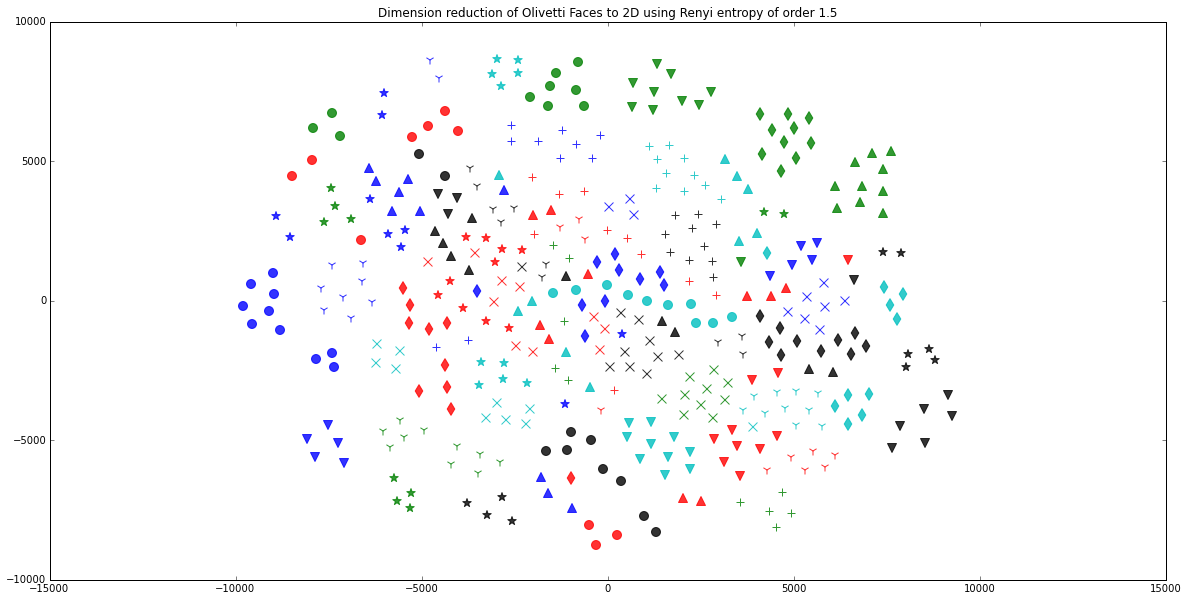

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

X_pca = np.loadtxt('olivetti_pca_50.csv', delimiter = ',')
X_pca = X_pca.astype(float)



# since we want 40 total markers
# we use 5 colors and 8 marker

marker_style = ['^', 'o', '+', '*', 'x', 'd', 'v', '1']
marker_color = ['b', 'g', 'r', 'c', 'k']


t = []
for style in marker_style:
    for color in marker_color:
        t.append((style, color))
                 
alphas = [1.5]

for alpha in alphas:
    Y = tsne_renyi2_npca(X_pca, alpha = alpha, max_iter= 10000)
    fig = plt.figure(figsize = (20, 10))
    marker = -1
    #figure(figsize = (20, 10))
    ax = fig.add_subplot(111)
    for i in xrange(Y.shape[0]):
        if i % 10 == 0:
            marker += 1
        ax.scatter(Y[i, 0], Y[i, 1], s = 80, marker = t[marker][0], c = t[marker][1], alpha = 0.8, edgecolor = t[marker][1])

    ax.set_title('Dimension reduction of Olivetti Faces to 2D using Renyi entropy of order ' + str(alpha))
    plt.show()

Computing pairwise distances...
Computing P-values for point  0  of  400 ...
Mean value of sigma:  4.52868578389
Iteration  1000 : error is  76.6559973677
Iteration  2000 : error is  58.4234126384
Iteration  3000 : error is  49.8944549207
Iteration  4000 : error is  44.1154852965
Iteration  5000 : error is  40.4345910455
Iteration  6000 : error is  36.9416122907
Iteration  7000 : error is  34.4236889847
Iteration  8000 : error is  32.7250337073
Iteration  9000 : error is  31.5980655642
Iteration  10000 : error is  30.4496109458
Iteration  11000 : error is  29.3454862346
Iteration  12000 : error is  28.378104957
Iteration  13000 : error is  27.6802190884
Iteration  14000 : error is  27.25161135
Iteration  15000 : error is  26.8648878876
Iteration  16000 : error is  26.6073237725
Iteration  17000 : error is  26.442977625
Iteration  18000 : error is  26.3553194412
Iteration  19000 : error is  26.3055025783
Iteration  20000 : error is  26.160892039


Computing pairwise distances...
Computing P-values for point  0  of  400 ...
Mean value of sigma:  4.52868578389
Iteration  1000 : error is  67.6596078462
Iteration  2000 : error is  47.3687160704
Iteration  3000 : error is  37.2343943885
Iteration  4000 : error is  31.9703464901
Iteration  5000 : error is  28.9553371461
Iteration  6000 : error is  27.4262481527
Iteration  7000 : error is  26.3655730862
Iteration  8000 : error is  25.3128299175
Iteration  9000 : error is  24.7866956319
Iteration  10000 : error is  24.5004300606
Iteration  11000 : error is  24.3782474656
Iteration  12000 : error is  24.3282806315
Iteration  13000 : error is  24.2127131987
Iteration  14000 : error is  24.0903546052
Iteration  15000 : error is  24.0282969967
Iteration  16000 : error is  23.9943289986
Iteration  17000 : error is  23.9335857986
Iteration  18000 : error is  23.8774423823
Iteration  19000 : error is  23.7923845197
Iteration  20000 : error is  23.781205777


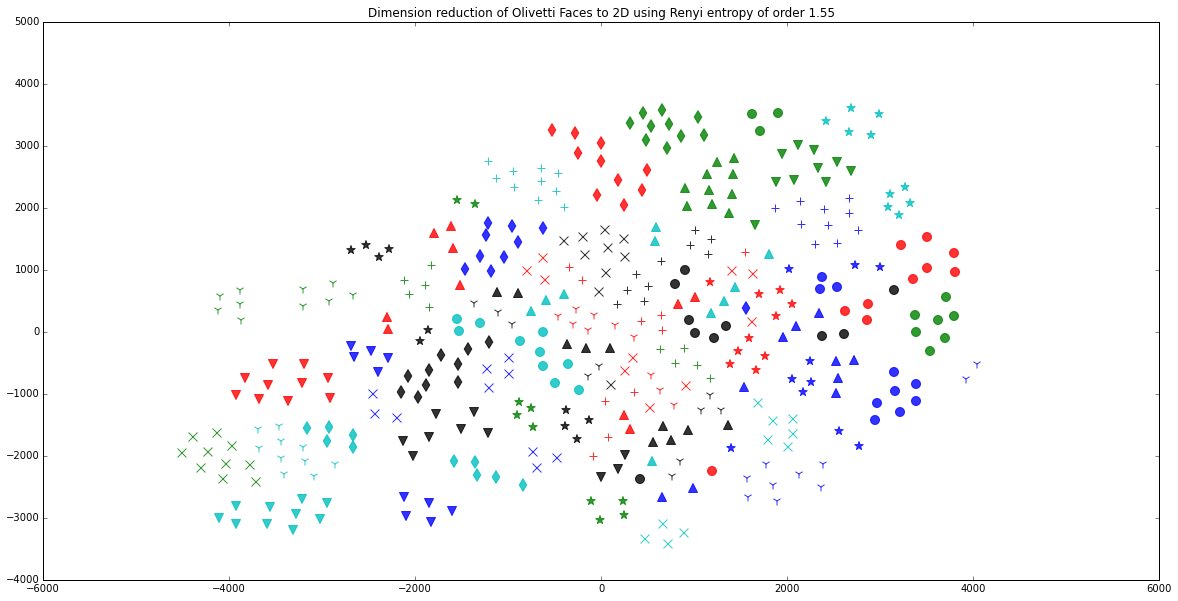

Computing pairwise distances...
Computing P-values for point  0  of  400 ...
Mean value of sigma:  4.52868578389
Iteration  1000 : error is  149.48046335
Iteration  2000 : error is  113.871300518
Iteration  3000 : error is  95.334922215
Iteration  4000 : error is  83.0436413833
Iteration  5000 : error is  75.8504913087
Iteration  6000 : error is  69.9624119835
Iteration  7000 : error is  65.1347376271
Iteration  8000 : error is  61.2749596859
Iteration  9000 : error is  57.3261007112
Iteration  10000 : error is  54.1231745813
Iteration  11000 : error is  50.6583164565
Iteration  12000 : error is  47.3253128341
Iteration  13000 : error is  45.0229820996
Iteration  14000 : error is  42.9344726581
Iteration  15000 : error is  41.1048270081
Iteration  16000 : error is  39.3247418644
Iteration  17000 : error is  37.8186346762
Iteration  18000 : error is  36.6144315489
Iteration  19000 : error is  35.532434787
Iteration  20000 : error is  34.6503624012


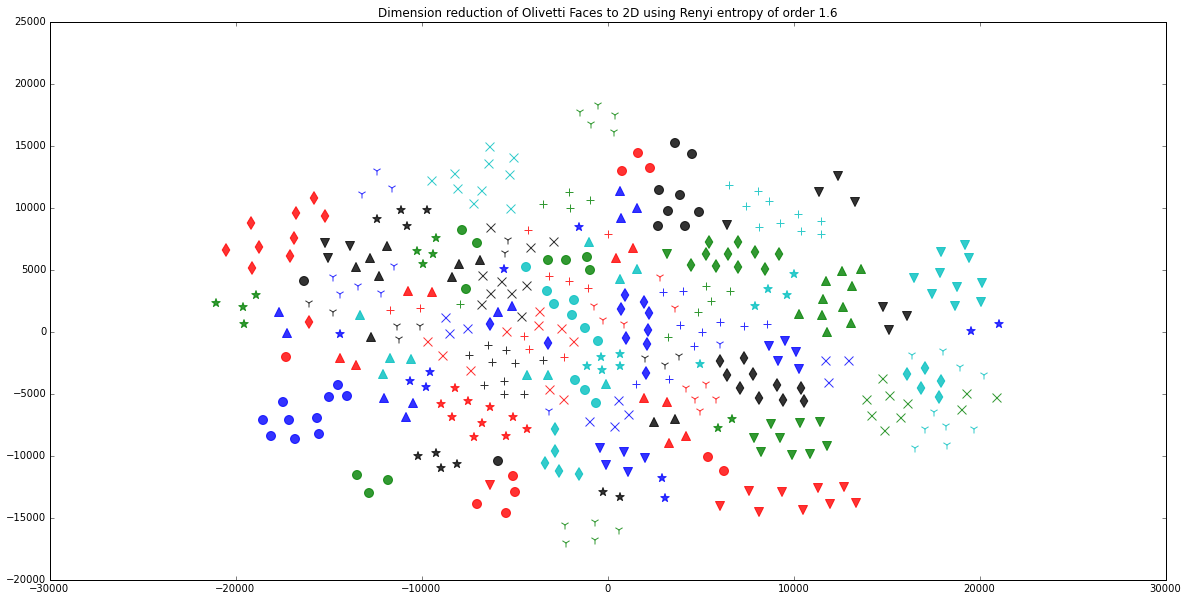

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

X_pca = np.loadtxt('olivetti_pca_50.csv', delimiter = ',')
X_pca = X_pca.astype(float)



# since we want 40 total markers
# we use 5 colors and 8 marker

marker_style = ['^', 'o', '+', '*', 'x', 'd', 'v', '1']
marker_color = ['b', 'g', 'r', 'c', 'k']


t = []
for style in marker_style:
    for color in marker_color:
        t.append((style, color))
                 
alphas = [1.5, 1.55, 1.6]

for alpha in alphas:
    Y = tsne_renyi2_npca(X_pca, alpha = alpha, max_iter= 20000)
    fig = plt.figure(figsize = (20, 10))
    marker = -1
    #figure(figsize = (20, 10))
    ax = fig.add_subplot(111)
    for i in xrange(Y.shape[0]):
        if i % 10 == 0:
            marker += 1
        ax.scatter(Y[i, 0], Y[i, 1], s = 80, marker = t[marker][0], c = t[marker][1], alpha = 0.8, edgecolor = t[marker][1])

    ax.set_title('Dimension reduction of Olivetti Faces to 2D using Renyi entropy of order ' + str(alpha))
    plt.show()